In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from ripple_heterogeneity.utils import (
    functions,
    loading,
    compress_repeated_epochs,
    batch_analysis,
    add_new_deep_sup,
    custom_plots
)
from ripple_heterogeneity.replay import replay_run, replay_fig, replay_participation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import pickle
import seaborn as sns
import nelpy as nel
import nelpy.plotting as npl
import random
from matplotlib.ticker import AutoMinorLocator


C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\plotting\decoding.py:9: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.


In [3]:
session = "Z:\\home\\ryanh\\projects\\ripple_heterogeneity\\replay\\Z__Data_GrosmarkAD_Achilles_Achilles_10252013.pkl"
with open(session, 'rb') as f:
    results = pickle.load(f)

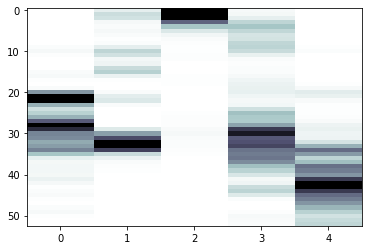

In [4]:
bst = results["outbound_epochs"]["bst_placecells"]
tc = results["outbound_epochs"]["tc"]
posterior, _, _, _ = nel.decoding.decode1D(
    bst=bst[126],
    ratemap=tc,
    xmin=tc.bins.min(),
    xmax=tc.bins.max()
)

plt.imshow(
    posterior,
    aspect="auto",
    interpolation="nearest",
    cmap="bone_r",
    vmax=0.1
)

In [5]:
from nelpy.decoding import get_mode_pth_from_array
diff_mode_pth = np.diff(get_mode_pth_from_array(posterior, tuningcurve=tc))
diff_mode_pth.mean(), diff_mode_pth.max()

(15.849056603773585, 87.54716981132074)

In [6]:
from ripple_heterogeneity.replay import score

In [7]:
(
    scores,
    avg_jump,
    scores_time_swap,
    scores_col_cycle,
    jump_col_cycle,
) = score.trajectory_score_bst(
    bst, tc, w=3, n_shuffles=250, weights=None, normalize=True
)


In [ ]:
plt.hist(jump_col_cycle[:,82],100)
plt.axvline(avg_jump[82],color="r")
plt.show()
# avg_jump.shape

In [ ]:
sig_idx, pval = functions.get_significant_events(scores,scores_time_swap)
print(sig_idx)
sig_idx, pval = functions.get_significant_events(scores,scores_col_cycle)
print(sig_idx)
sig_idx, pval = functions.get_significant_events(avg_jump,jump_col_cycle, tail="right")
print(sig_idx)